In [1]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pandas as pd
import glob
from pathlib import Path
import matplotlib.image as mpimg
import os
import json
from PIL import Image, ImageEnhance, ImageOps, ImageFilter

In [51]:
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
folder_path = r"C:\Users\misty\research_assistant_working_folder\images"
for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):
        img = Image.open(os.path.join(folder_path, filename))
        img.show() # Plot all the images
        # Normalize pixel values to the range [0, 1]
        img_normalized = np.array(img) / 255.0

        # Enhance brightness and contrast
        enhancer = ImageEnhance.Brightness(img)
        img_bright = enhancer.enhance(1)  # Increase brightness
        enhancer = ImageEnhance.Contrast(img_bright)
        img_contrast = enhancer.enhance(1)  # Increase contrast

        # Apply Gaussian Blur for noise reduction
        img_filtered = img_contrast.filter(ImageFilter.GaussianBlur(radius=2))
        sharpness_factor = 2.0
        enhancer = ImageEnhance.Sharpness(img_filtered) 
        img_sharpened = enhancer.enhance(sharpness_factor)  # Enhance sharpness

        # Perform histogram equalization for contrast adjustment
        img_equalized = ImageOps.equalize(img_sharpened.convert('RGB'))

        # Save the cleaned and enhanced image
        cleaned_filename = f"cleaned_{filename}"
        img_equalized.save(cleaned_filename)
        print("Image has been processed!")

Image has been processed!
Image has been processed!
Image has been processed!
Image has been processed!
Image has been processed!
Image has been processed!


In [39]:
# I found 3 satellite images online that contains buildiing, airplanes, cars and trucks
# Used labelImg to label these three images and run the code below to train my customized model
!cd yolov5 && python train.py --img 640 --batch 8 --epochs 500 --data dataset.yml --weights yolov5s.pt --workers 2

train: weights=yolov5s.pt, cfg=, data=dataset.yml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=500, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github:  YOLOv5 is out of date by 16 commits. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  v7.0-231-gc2f131a Python-3.8.12 torch-1.13.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, h

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\misty/.cache\torch\hub\master.zip
YOLOv5  2023-11-23 Python-3.8.12 torch-1.13.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7058671 parameters, 0 gradients
Adding AutoShape... 


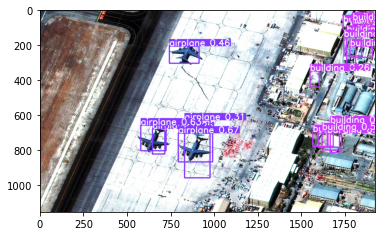

In [46]:
# load the model and output testing images with predicted box
model = torch.hub.load('ultralytics/yolov5', 'custom', path = 'yolov5/runs/train/exp2/weights/last.pt', force_reload=True)
image_path = r"C:\Users\misty\research_assistant_working_folder\cleaned_image_6.jpg" # I used Image_6 as an example
results = model(image_path)

# Plotting the image with detections
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

In [47]:
label = []
for filename in glob.glob(r"C:\Users\misty\research_assistant_working_folder\cleaned_image_" + "*.jpg"): 
    frame = cv2.imread(filename)
    detections = model(frame[..., ::-1])  # Assuming 'model' is your YOLOv5 model
    results = detections.pandas().xyxy[0]

    # Store each detection in a list
    for index, result in results.iterrows():
        detection = result.to_dict()
        detection['filename'] = filename  # Add filename for reference
        label.append(detection)
# Convert to a DataFrame
df = pd.DataFrame(label)
print(df)

            xmin        ymin         xmax        ymax  confidence  class  \
0      32.384560  561.587708   121.645615  582.383911    0.606526     17   
1      66.015518  553.919800   106.993080  595.033020    0.563872     17   
2     426.880005   76.963272   477.479279  112.890106    0.534961     17   
3     784.358459  184.804871   834.357788  214.681870    0.471730     17   
4     704.745361  308.794678   755.222534  348.812073    0.453240     17   
..           ...         ...          ...         ...         ...    ...   
166  1594.875366  704.806274  1650.150513  784.105408    0.274583     17   
167  1737.664795   30.584450  1920.000000  112.454842    0.269735     17   
168  1547.836304  348.674500  1600.430054  440.214691    0.261123     17   
169   644.376953  679.574524   715.530762  823.820068    0.251240     15   
170  1663.363525  646.116882  1716.981201  815.107544    0.250297     17   

         name                                           filename  
0    building  C:\Us

In [49]:
with open(r'C:\Users\misty\research_assistant_working_folder\data\labels\classes.txt', 'r') as file:
    class_names = [line.strip() for line in file.readlines()]
def bbox_to_polygon(bbox):
    """
    Converts bounding box to polygon vertices.

    Parameters:
    bbox (dict): A dictionary with keys 'xmin', 'ymin', 'xmax', 'ymax'.

    Returns:
    list: Polygon vertices in GeoJSON format.
    """
    x_min, y_min, x_max, y_max = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
    return [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]]


# Initialize the GeoJSON structure
geojson = {
    "type": "FeatureCollection",
    "features": []
}

for detection in df.to_dict(orient="records"):
    # Convert bounding box to polygon (in geographical coordinates)
    polygon = bbox_to_polygon(detection)
    # Get the class name instead of class number
    class_name = class_names[detection['class']]
    
    # Add this polygon to the GeoJSON structure
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [polygon]
        },
        "properties": {
            "class": class_name,
            "confidence": detection['confidence']
        }
    }
    geojson['features'].append(feature)

# Save to a GeoJSON file
with open('buildings_footprints.geojson', 'w') as f:
    json.dump(geojson, f)
# Print out the json file
geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[32.384559631347656, 561.5877075195312],
      [121.64561462402344, 561.5877075195312],
      [121.64561462402344, 582.3839111328125],
      [32.384559631347656, 582.3839111328125],
      [32.384559631347656, 561.5877075195312]]]},
   'properties': {'class': 'building', 'confidence': 0.6065255403518677}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[66.01551818847656, 553.9197998046875],
      [106.99308013916016, 553.9197998046875],
      [106.99308013916016, 595.0330200195312],
      [66.01551818847656, 595.0330200195312],
      [66.01551818847656, 553.9197998046875]]]},
   'properties': {'class': 'building', 'confidence': 0.5638715028762817}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[426.8800048828125, 76.96327209472656],
      [477.4792785644531, 76.96327209472656],
      [477.4792785644531, 1